In [168]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd
from matplotlib.pyplot import pie, axis, show

In [3]:
import tweepy
# Set Twitter API credentials
consumer_key = "**************************"
consumer_secret = "**************************************************"
access_key = "**********************************************************"
access_secret = "************************************************"
# authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [4]:
#api.update_status('Test')

user = api.me()
 
print('Name: ' + user.name)
print('Location: ' + user.location)
print('Friends: ' + str(user.friends_count))

Name: Akanksha
Location: 
Friends: 40


### Downloading tweets for Modi

In [61]:
#s1=tweepy.Cursor(api.search,q="Modi -filter:retweets",since=datetime.date(2019, 4, 1),until=datetime.date(2019, 4, 28),
                 #lang='en').items(10000)
#search = tweepy.Cursor(api.search, q="Modi -filter:retweets", result_type="recent", lang="en",since="2019-04-01",
#until="2019-04-30")

search = tweepy.Cursor(api.search, q="Modi -filter:retweets",lang="en").items(1000)
text = []
date = []
for item in search:    
    # tweet text
    text.append(item.text)
    
    # tweet created date 
    date.append(item.created_at)
df = pd.DataFrame({'text':text, 'date':date})
df.shape
df.to_csv('Modi.csv')

### Downloading tweets for Kejriwal

In [71]:
search = tweepy.Cursor(api.search, q="Kejriwal -filter:retweets",lang="en").items(1000)
text = []
date = []
for item in search:    
    # tweet text
    text.append(item.text)
    
    # tweet created date 
    date.append(item.created_at)
df = pd.DataFrame({'text':text, 'date':date})
df.shape
df.to_csv('Kejriwal.csv')

In [86]:
Kejri=pd.read_csv("Kejriwal.csv")
Kejri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
Unnamed: 0    1000 non-null int64
text          1000 non-null object
date          1000 non-null object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


### Number of Words

In [87]:
Kejri['word_count'] = Kejri['text'].apply(lambda x: len(str(x).split(" ")))
Kejri[['text','word_count']].head()

,text,word_count
0,@moneycontrolcom @arivalayam @mkstalin He is n...,18
1,"Sort, only kejriwal ji can answer this questio...",21
2,@AzmiShabana Are you tweeting from some other ...,20
3,@MajorPoonia @CitiznMukherjee @narendramodi sa...,7
4,@BhagwantMann Doing greatest job which none ha...,23


### Number of characters

In [88]:
Kejri['char_count'] = Kejri['text'].str.len() ## this also includes spaces 
Kejri[['text','char_count']].head()

,text,char_count
0,@moneycontrolcom @arivalayam @mkstalin He is n...,121
1,"Sort, only kejriwal ji can answer this questio...",133
2,@AzmiShabana Are you tweeting from some other ...,140
3,@MajorPoonia @CitiznMukherjee @narendramodi sa...,70
4,@BhagwantMann Doing greatest job which none ha...,140


### Average Word Length

In [89]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
Kejri['avg_word'] = Kejri['text'].apply(lambda x: avg_word(x))
Kejri[['text','avg_word']].head()

,text,avg_word
0,@moneycontrolcom @arivalayam @mkstalin He is n...,5.777778
1,"Sort, only kejriwal ji can answer this questio...",5.380952
2,@AzmiShabana Are you tweeting from some other ...,6.050000
3,@MajorPoonia @CitiznMukherjee @narendramodi sa...,9.142857
4,@BhagwantMann Doing greatest job which none ha...,5.130435


### Number of stopwords

In [90]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
Kejri['stopwords'] = Kejri['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
Kejri[['text','stopwords']].head()

,text,stopwords
0,@moneycontrolcom @arivalayam @mkstalin He is n...,6
1,"Sort, only kejriwal ji can answer this questio...",8
2,@AzmiShabana Are you tweeting from some other ...,8
3,@MajorPoonia @CitiznMukherjee @narendramodi sa...,1
4,@BhagwantMann Doing greatest job which none ha...,9


### Number of special characters

In [91]:
Kejri['hastags'] = Kejri['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
Kejri[['text','hastags']].head()

,text,hastags
0,@moneycontrolcom @arivalayam @mkstalin He is n...,0
1,"Sort, only kejriwal ji can answer this questio...",0
2,@AzmiShabana Are you tweeting from some other ...,0
3,@MajorPoonia @CitiznMukherjee @narendramodi sa...,1
4,@BhagwantMann Doing greatest job which none ha...,0


### Number of Uppercase words

In [92]:
Kejri['upper'] = Kejri['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
Kejri[['text','upper']].head()

,text,upper
0,@moneycontrolcom @arivalayam @mkstalin He is n...,0
1,"Sort, only kejriwal ji can answer this questio...",0
2,@AzmiShabana Are you tweeting from some other ...,1
3,@MajorPoonia @CitiznMukherjee @narendramodi sa...,0
4,@BhagwantMann Doing greatest job which none ha...,0


### Converting to lower case


In [93]:
Kejri['text'] = Kejri['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Kejri['text'].head()

0    @moneycontrolcom @arivalayam @mkstalin he is n...
1    sort, only kejriwal ji can answer this questio...
2    @azmishabana are you tweeting from some other ...
3    @majorpoonia @citiznmukherjee @narendramodi sa...
4    @bhagwantmann doing greatest job which none ha...
Name: text, dtype: object

### Removing twitter handles

In [94]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt
# remove twitter handles (@user)
Kejri['text'] = np.vectorize(remove_pattern)(Kejri['text'], "@[\w]*")
Kejri[['text']].head()

,text
0,"he is not going to resign anyway, he is jus..."
1,"sort, only kejriwal ji can answer this questio..."
2,are you tweeting from some other country? i b...
3,sadji is missing #kejriwal
4,doing greatest job which none has done so far...


### Removing Punctuation

In [95]:
Kejri['text'] = Kejri['text'].str.replace("[^\w\s]", " ") #[^a-zA-Z#]
Kejri[['text']].head(10)

,text
0,he is not going to resign anyway he is jus...
1,sort only kejriwal ji can answer this questio...
2,are you tweeting from some other country i b...
3,sadji is missing kejriwal
4,doing greatest job which none has done so far...
5,i can relate to this very well someone who is...
6,what you said is really good for aap but i...
7,mamata banerjee is devi for bengalis and your ...
8,delhi chief minister arvind kejriwal gets crac...
9,aap will break 2015 delhi assembly poll record...


### removing https from each tweet

In [96]:
Kejri["text"] = list(map(lambda x: x.split("https")[0], Kejri["text"]))
Kejri.text.head()

0       he is not going to resign anyway  he is jus...
1    sort  only kejriwal ji can answer this questio...
2     are you tweeting from some other country  i b...
3                           sadji is missing  kejriwal
4     doing greatest job which none has done so far...
Name: text, dtype: object

### Removal of Stop Words

In [97]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
Kejri['text'] = Kejri['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
Kejri['text'].head()

0    going resign anyway pure nautanki like natwarl...
1    sort kejriwal ji answer question knows google ...
2    tweeting country believe left india per earlie...
3                               sadji missing kejriwal
4     greatest job none done far whole world aware mak
Name: text, dtype: object

### Most frequent words

In [125]:
freq = pd.Series(' '.join(Kejri['text']).split()).value_counts()[:50]

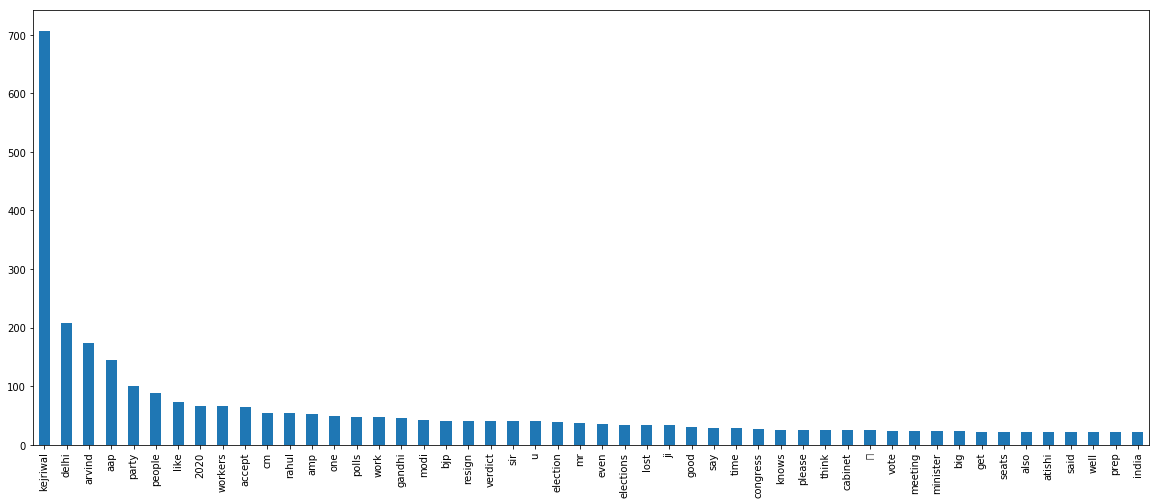

In [99]:
plt.figure(figsize=(20,8))
freq.plot.bar()
plt.show()

In [146]:
useless=['kejriwal',
 'delhi',
 'arvind',
 'aap',
 'party',
 'cm',
 'rahul',
 'polls',
 'gandhi',
 'modi',
 'bjp',
 'congress',
 'ल',
 'vote',
 'meeting',
 'minister',
 'get',
 'seats',
 'also',
 'atishi',
 'said',
 'prep',
 'india','sir','take','make','election','mr','people','person','want','amp','elections','state','please','think','chief'
         ,'one'
        ]

In [147]:
Kejri['text'] = Kejri['text'].apply(lambda x: " ".join(x for x in x.split() if x not in useless))
Kejri['text'].head()

0     going resign anyway pure nautanki like natwarlal
1    sort ji answer question knows google winning w...
2    tweeting country believe left per earlier stat...
3                                        sadji missing
4     greatest job none done far whole world aware mak
Name: text, dtype: object

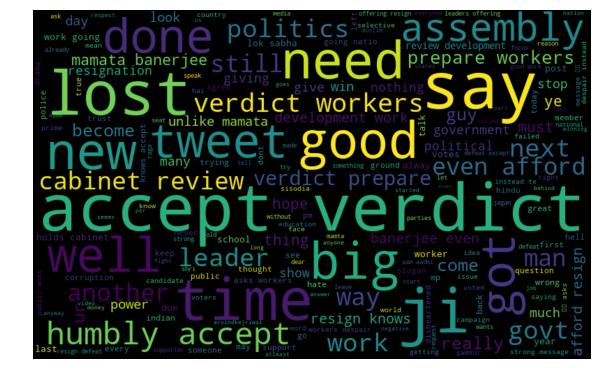

In [148]:
#A) Understanding the common words used in the tweets: WordCloud
all_words = ' '.join([text for text in Kejri['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Tokenization

In [149]:
from textblob import TextBlob

In [191]:
#tokens
tokenized_tweet = Kejri['text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [going, resign, anyway, pure, nautanki, like, ...
1    [sort, ji, answer, question, knows, google, wi...
2    [tweeting, country, believe, left, per, earlie...
3                                     [sadji, missing]
4    [greatest, job, none, done, far, whole, world,...
Name: text, dtype: object

### Stemming not required, doing lemmatization instead

In [193]:
from textblob import Word
Kejri['lem'] = Kejri['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
Kejri.lem.head()

0     going resign anyway pure nautanki like natwarlal
1    sort ji answer question know google winning wo...
2    tweeting country believe left per earlier stat...
3                                        sadji missing
4     greatest job none done far whole world aware mak
Name: lem, dtype: object

## Sentiment Analysis

In [159]:
import collections
import nltk.metrics
from nltk.classify import NaiveBayesClassifier

In [160]:
def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

In [161]:
sentiment=[]
for i in Kejri.lem:
    sentiment.append(get_tweet_sentiment(Kejri,i))

In [185]:
Kejri['sentiment']=sentiment

In [186]:
a=Kejri.sentiment.value_counts()

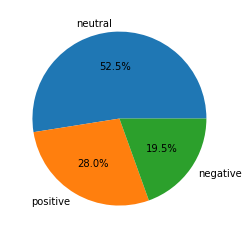

In [197]:
pie(a.values, labels=a.index,autopct='%1.1f%%')
plt.show()

In [189]:
Kejri.to_csv('result.csv')

# Doing the same for tweets for Modi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
Unnamed: 0    1000 non-null int64
text          1000 non-null object
date          1000 non-null object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


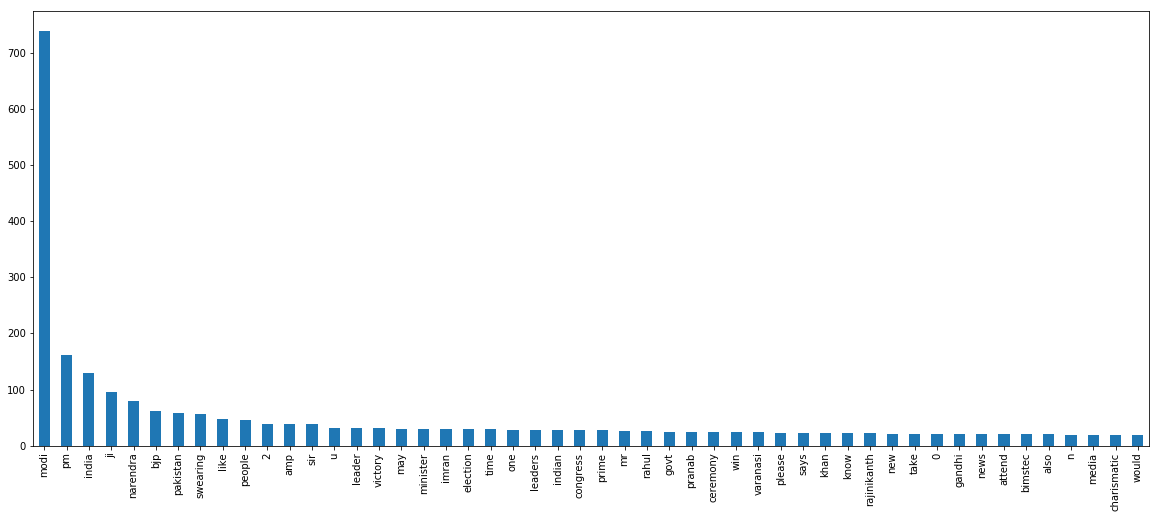

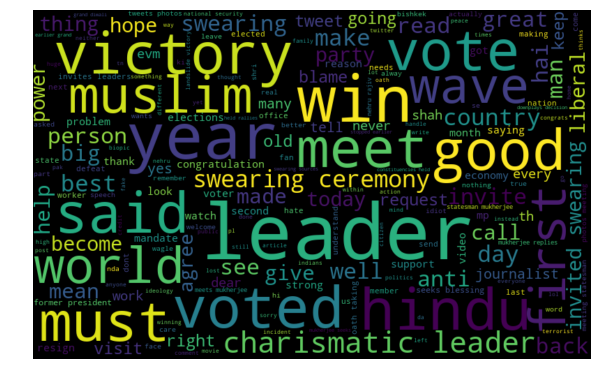

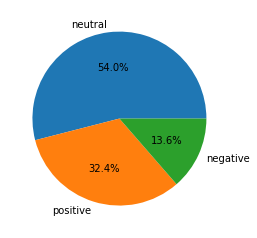

In [200]:
Modi=pd.read_csv("Modi.csv")
Modi.info()
Modi['word_count'] = Modi['text'].apply(lambda x: len(str(x).split(" ")))
Modi[['text','word_count']].head()
Modi['char_count'] = Modi['text'].str.len() ## this also includes spaces 
Modi[['text','char_count']].head()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
Modi['avg_word'] = Modi['text'].apply(lambda x: avg_word(x))
Modi[['text','avg_word']].head()
from nltk.corpus import stopwords
stop = stopwords.words('english')
Modi['stopwords'] = Modi['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
Modi[['text','stopwords']].head()
Modi['hastags'] = Modi['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
Modi[['text','hastags']].head()
Modi['upper'] = Modi['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
Modi[['text','upper']].head()
Modi['text'] = Modi['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Modi['text'].head()
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt
# remove twitter handles (@user)
Modi['text'] = np.vectorize(remove_pattern)(Modi['text'], "@[\w]*")
Modi[['text']].head()
Modi['text'] = Modi['text'].str.replace("[^\w\s]", " ") #[^a-zA-Z#]
Modi[['text']].head(10)
Modi["text"] = list(map(lambda x: x.split("https")[0], Modi["text"]))
Modi.text.head()
from nltk.corpus import stopwords
stop = stopwords.words('english')
Modi['text'] = Modi['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
Modi['text'].head()
freq = pd.Series(' '.join(Modi['text']).split()).value_counts()[:50]
plt.figure(figsize=(20,8))
freq.plot.bar()
plt.show()
useless=['modi', 'pm', 'india', 'ji', 'narendra', 'bjp', 'people', '2', 'amp', 'sir', 'u', 'may',
       'minister', 'imran', 'election', 'time', 'one', 'congress',
       'prime', 'indian', 'mr', 'rahul', 'govt', 'pranab', 'varanasi','please', 'says', 'know', 'khan', 'rajinikanth',
       'new', '0', 'take', 'also', 'attend', 'bimstec', 'gandhi', 'news',
       'would', 'media', 'government','pakistan','want','need','even','say','think']
Modi['text'] = Modi['text'].apply(lambda x: " ".join(x for x in x.split() if x not in useless))
Modi['text'].head()
#A) Understanding the common words used in the tweets: WordCloud
all_words = ' '.join([text for text in Modi['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
from textblob import Word
Modi['lem'] = Modi['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
Modi.lem.head()
def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
sentiment=[]
for i in Modi.lem:
    sentiment.append(get_tweet_sentiment(Modi,i))
Modi['sentiment']=sentiment
a=Modi.sentiment.value_counts()
pie(a.values, labels=a.index,autopct='%1.1f%%')
plt.show()

In [201]:
Modi.sentiment.head()

0     neutral
1     neutral
2    negative
3    positive
4    positive
Name: sentiment, dtype: object

# We see that for Modi there is more positive sentiment as compared to Arvind Kejriwal